In [181]:
import numpy as np
import pandas as pd
import random
import boto3
import tensorflow as tf
from numpy.testing import assert_allclose
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
client = boto3.client('s3')

bucket = 'smilesmolecules'

In [4]:
def get_files(client, bucket):
    length = 0
    csv_files = []
    content = client.list_objects(Bucket=bucket).get('Contents')
    for obj in content:
        if length > 50:
            break
        key = obj.get('Key')
        
        if '.smi' in key:
                csv_files.append(key)
                length += 1 
    return csv_files

test = get_files(client, bucket)
len(test)

51

In [5]:
'''
The whole S3 bucket contains more than 900 million molecules. We'll grab around 10 million as a starter.
'''

df = []

split1 = test[:50]

for obj in split1:
    dataframe = pd.read_csv('s3://smilesmolecules/' + obj, delimiter = ' ')
    df.append(dataframe)

    
df1 = pd.concat(df)

In [6]:
df1 = df1.iloc[:1000000, 0]
molecules = df1.tolist()

In [6]:
'''
Need to map each character to an int
'''
unique_chars = sorted(list(set(''.join(molecules[:500000]))))
print('Number of unique characters in the molecules set:', len(unique_chars))

('Number of unique characters in the molecules set:', 34)


In [7]:
char_to_int = {c: i for i, c in enumerate(unique_chars)}

In [9]:
text = ''.join(molecules[:500])

In [16]:
X = np.array([])
y = np.array([])
for i in range(0, len(text) - 300):
    seq_X = text[i:i + 300]
    seq_y = text[i + 300]
    X = np.append(X, [char_to_int[char] for char in seq_X])
    y = np.append(y, [char_to_int[char] for char in seq_y])

In [ ]:
y

In [17]:
X = np.reshape(X, (-1, 300, 1))

X = X / len(unique_chars)

y = np_utils.to_categorical(y)

print(X.shape)
print(y.shape)

(18902, 300, 1)
(18902, 34)


In [18]:
'''Create the LSTM Model'''

model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences= True))
model.add(Dropout(0.25))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(.25))

model.add(LSTM(512, return_sequences = True))
model.add(Dropout(0.20))

model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.20))

model.add(LSTM(128))
model.add(Dropout(0.20))

model.add(Dense(y.shape[1], activation = 'softmax'))

In [ ]:
print(model.summary())

In [23]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [ ]:
#Checkpoint
filepath = 'improved-weights-{epoch:02d}-{loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only= True, mode = 'min')
callback = [checkpoint]

#Fitting
model.fit(X, y, epochs = 6, batch_size= 512, callbacks = callback)

In [31]:
new_text = ''.join(molecules[1000:2500])

X_train = np.array([])
y_train = np.array([])
for i in range(0, len(new_text) - 300):
    seq_X = new_text[i:i + 300]
    seq_y = new_text[i + 300]
    X_train = np.append(X_train, [char_to_int[char] for char in seq_X])
    y_train = np.append(y_train, [char_to_int[char] for char in seq_y])

In [32]:
X_train = np.reshape(X_train, (-1, 300, 1))

X_train = X_train / len(unique_chars)

y_train = np_utils.to_categorical(y_train)

print(X_train.shape)
print(y_train.shape)

(54836, 300, 1)
(54836, 34)


In [19]:
'''From saved checkpoint'''

model.load_weights('improved-weights-05-2.5474.hdf5')

In [24]:
new_model = load_model('improved-weights-05-2.5474.hdf5')
assert_allclose(model.predict(X_train), new_model.predict(X_train), 1e-5)

KeyboardInterrupt: 

In [25]:
filepath = 'improved-weights-{epoch:02d}-{loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor= 'loss', verbose=1, save_best_only=True, mode = 'min')
callback = [checkpoint]

In [ ]:
model.fit(X_train, y_train, epochs = 4, batch_size = 128, callbacks = callback)

Epoch 1/4
54836/54836 [==============================] - 8154s 149ms/step - loss: 2.5741

Epoch 00001: loss improved from inf to 2.57409, saving model to improved-weights-01-2.5741.hdf5
Epoch 2/4
54836/54836 [==============================] - 8165s 149ms/step - loss: 2.5665

Epoch 00002: loss improved from 2.57409 to 2.56654, saving model to improved-weights-02-2.5665.hdf5
Epoch 3/4
45568/54836 [=======================>......] - ETA: 22:59 - loss: 2.5662

In [88]:
'''Load in the pre trained network weights '''

filename = 'improved-weights-02-2.5768.hdf5'
model.load_weights(filename)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [49]:
testing_text = ''.join(molecules[5000:7500])

X = []

for i in range(0, len(new_text) - 300):
    seq_X = new_text[i:i + 300]
    X.append([char_to_int[char] for char in seq_X])


In [166]:
'''See if we can produce a molecule with a random string'''

start = np.random.randint(0, 50)
pattern = X[start]
print(''.join([int_to_char[val] for val in pattern[:100]]))

n1c2nc(NCCN)[nH]c2c(=O)[nH]c1=OCOC(=O)[C@](C)(O)[C@@](C)(O)C(=O)OCNc1ncnc2c1ncn2[C@H](N)C(=O)ONc1ncn


In [40]:
int_to_char = {i: c for i, c in enumerate(unique_chars)}

In [167]:
for i in range(50):
    x = np.reshape(pattern, (1, len(pattern), 1))
    pred = model.predict(x)
    
    top_5 = np.argsort(pred)[::-1]
    index = random.choice(top_5[0][-5:])
    result = int_to_char[index]
    seq = [int_to_char[val] for val in pattern]
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

In [178]:
print(''.join([int_to_char[val] for val in pattern]))

@@](C)(O)C(=O)OCNc1ncnc2c1ncn2[C@H](N)C(=O)ONc1ncnc2c1ncn2[C@@H](N)C(=O)OCS(=O)(=O)CC[C@H](N)P(=O)(O)OC[C@@H](CS(=O)(=O)O)NC(CO)(CO)COO=c1[nH]c(=O)c2nn3nnnc3nc2[nH]1Cn1c(C=O)nc2c1c(=O)n(C)c(=O)n2CO=C(Nc1cc(=O)[nH]c(=O)[nH]1)c1nc[nH]n1C[C@@H]1CC(=O)N=OC(CC(C)O)@OCO(OC@)@C@@C)O()(O)@C)@))((O)C(O)C@()C


In [184]:
#Define the molecule of interest
penicillin_smile = 'CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)Cc3ccccc3)C(=O)O)C'
penicillin = Chem.MolFromSmiles(penicillin_smile)

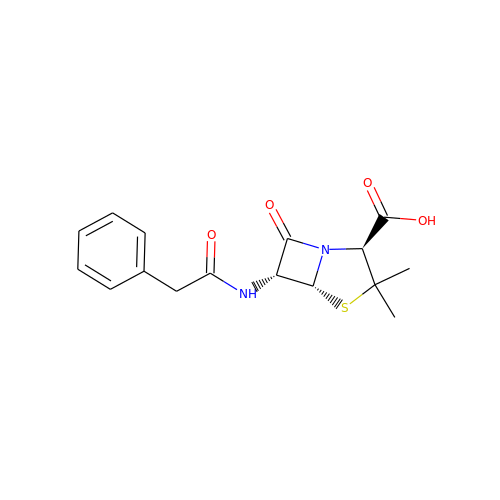

In [191]:
#Draw
Draw.MolToImage(penicillin, size = (500,500))

In [192]:
risdiplam_smiles = 'CC1=CN2N=C(C=C(C)C2=N1)C1=CC(=O)N2C=C(C=CC2=N1)N1CCNC2(CC2)C1'
risdiplam_mol = Chem.MolFromSmiles(risdiplam_smiles)

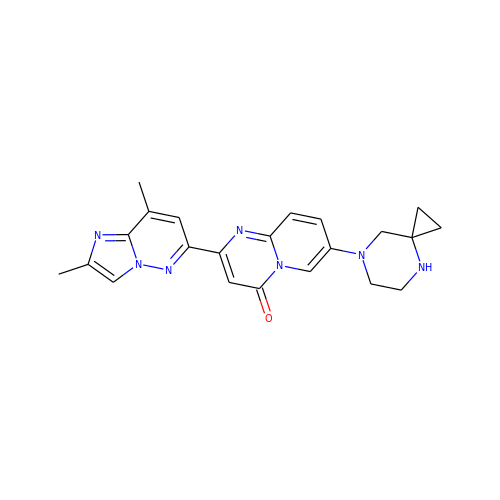

In [194]:
Draw.MolToImage(risdiplam_mol, size = (500,500))

In [195]:
len(risdiplam_smiles)

61

In [208]:
fragment = risdiplam_smiles


In [209]:
fragment = [char_to_int[val] for val in fragment]


In [210]:
for i in range(50):
    x = np.reshape(fragment, (1, len(fragment), 1))
    pred = model.predict(x)
    
    top_5 = np.argsort(pred)[::-1]
    index = random.choice(top_5[0][-5:])
    result = int_to_char[index]
    seq = [int_to_char[val] for val in fragment]
    fragment.append(index)
    fragment = fragment[1:len(fragment)]

ValueError: Error when checking input: expected lstm_1_input to have shape (300, 1) but got array with shape (61, 1)